# 1) Import Libraries

In [18]:
import pandas as pd
import os
import requests
import io
import numpy as np
import datetime
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 2) Import Data
## 2.1) Set Folder Path

In [19]:
PATH = 'C:\\Users\\Desmond\\Desktop\\College\\Machine Learning' # should be the only path used in the future. Jupyter notebook has to be launched from
print(os.getcwd())

C:\Users\Desmond\Downloads


## 2.2) Import Air Quality data from Local Path

Here we import the air quality data from our folder path and rename the pollutants by removing a space so they work seamlessly in our code. 

We then get an overview of our data and identify that the columns in our file need to be converted to 'int64'.

Finally 'datetime_is_numeric = True' is used to silence a known Python warning.

In [20]:
# Select one of the paths here
air_PATH = os.path.join(PATH, 'new-york-air-quality.csv')
air = pd.read_csv(air_PATH, parse_dates = ['date'])
print(air.columns) # renaming neccesary for the last 4 columns
air.rename(columns={' pm25': 'pm25', ' o3': 'o3', ' no2': 'no2', ' co': 'co'}, inplace = True)

# Overview
air.info() # We can see that the columns in air need to be converted to 'int64'
air.describe(include = 'all', datetime_is_numeric = True) # 'datetime_is_numeric = True' is used to silence a known Python warning
print(air.head())

Index(['date', ' pm25', ' o3', ' no2', ' co'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3207 entries, 0 to 3206
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3207 non-null   datetime64[ns]
 1   pm25    3207 non-null   object        
 2   o3      3207 non-null   object        
 3   no2     3207 non-null   object        
 4   co      3207 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 125.4+ KB
        date pm25  o3 no2 co
0 2022-01-11   40  28  20  3
1 2022-02-11   45  23  25  3
2 2022-03-11   53  17  26  4
3 2022-04-11   47  24  10  1
4 2022-05-11   31  21   6  1


C:\Users\Desmond\anaconda3\lib\site-packages\pandas\io\parsers\base_parser.py:1070: UserWarning:

Parsing '13/11/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\Desmond\anaconda3\lib\site-packages\pandas\io\parsers\base_parser.py:1070: UserWarning:

Parsing '14/11/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\Desmond\anaconda3\lib\site-packages\pandas\io\parsers\base_parser.py:1070: UserWarning:

Parsing '15/11/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\Desmond\anaconda3\lib\site-packages\pandas\io\parsers\base_parser.py:1070: UserWarning:

Parsing '17/11/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\Desmond\anaconda3\lib\site-packages\pandas\io\parsers\base_parser.py:1070: UserWarning:

Parsing '18/11/2022' in DD

## 2.3) Import NYC Health data from Github repository

We then repeat the previous step for NYC health data.

In [7]:
url_health = 'https://raw.githubusercontent.com/nychealth/coronavirus-data/master/trends/data-by-day.csv'
download_health = requests.get(url_health).content
health = pd.read_csv(io.StringIO(download_health.decode('utf-8')), sep = ',', parse_dates= ['date_of_interest'])

# Overview
health.info()
health.describe(include = 'all', datetime_is_numeric = True) # 'datetime_is_numeric = True' is used to silence a known Python warning
print(health.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037 entries, 0 to 1036
Data columns (total 67 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date_of_interest                 1037 non-null   datetime64[ns]
 1   CASE_COUNT                       1037 non-null   int64         
 2   PROBABLE_CASE_COUNT              1037 non-null   int64         
 3   HOSPITALIZED_COUNT               1037 non-null   int64         
 4   DEATH_COUNT                      1037 non-null   int64         
 5   PROBABLE_DEATH_COUNT             1037 non-null   int64         
 6   CASE_COUNT_7DAY_AVG              1037 non-null   int64         
 7   ALL_CASE_COUNT_7DAY_AVG          1037 non-null   int64         
 8   HOSP_COUNT_7DAY_AVG              1037 non-null   int64         
 9   DEATH_COUNT_7DAY_AVG             1037 non-null   int64         
 10  ALL_DEATH_COUNT_7DAY_AVG         1037 non-null   int64      

# 3) Process and merge data
## 3.1) Process data

Here we process and merge the data. 

First of all we create a function to convert the date column and sort the data by date and then apply this to the air and health data.

We then find any missing date rows in the datasets and create a function to add the missing rows.

In [24]:
# 3.1.1) Convert the date column and sort the data by dates; Print the date range

def convert_sort_date_rows(data, date_column_name):
    
    # Use date_column_name to create a column index number
    date_column_index = data.columns.get_loc(date_column_name)
    
    # Convert datetime column to date-format without loosing the Dtype 'datetime64[ns]'
    data.iloc[:, date_column_index] = pd.to_datetime(data.iloc[:, date_column_index])
    
    # Sort by date_column_name and print the date range
    data = data.sort_values(by = date_column_name)
    date_range_min = min(data.iloc[:, date_column_index].dt.strftime('%Y-%m-%d'))
    date_range_max = max(data.iloc[:, date_column_index].dt.strftime('%Y-%m-%d'))
    print(f'Date range: {date_range_min}, {date_range_max}')
    
    return(data)

In [22]:
# 3.1.2) Apply the convert_sort_date_rows() function to air data
air = convert_sort_date_rows(data = air, date_column_name = 'date')

Date range: 2014-01-01, 2022-12-11


In [10]:
# 3.1.3) Apply the convert_sort_date_rows() function to health data
health = convert_sort_date_rows(data = health, date_column_name = 'date_of_interest')

# We can see that no date range includes the other. We therefore need an outer merge in 3.2)

Date range: 2020-02-29, 2022-12-31


In [11]:
# 3.1.4) Find missing date rows in both air and health and add the missing rows

def add_missing_date_rows(data, date_column_name):
    
    # Before dropping the date_column_name (see below): Use it to create a column index number and the date range min/max
    date_column_index = data.columns.get_loc(date_column_name)
    date_range_min = min(data.iloc[:, date_column_index].dt.strftime('%Y-%m-%d'))
    date_range_max = max(data.iloc[:, date_column_index].dt.strftime('%Y-%m-%d'))
    data = data.set_index(date_column_name, drop = True) # Set date as index; the original date_column_name is dropped here
    
    # Find missing date rows
    data.index = pd.to_datetime(data.index) # format to date time object
    date_missing_before = pd.date_range(start = str(date_range_min), end = str(date_range_max)).difference(data.index)
    print(str(date_missing_before.size) + " date rows are missing (before fix)")
    print(date_missing_before) 
    
    # Add the missing date rows
    date_range = pd.date_range(str(date_range_min), str(date_range_max)) # creates perfect date range
    data.index = pd.DatetimeIndex(data.index)
    data = data.reindex(date_range)
    date_missing_after = pd.date_range(start = str(date_range_min), end = str(date_range_max)).difference(data.index)
    print(str(date_missing_after.size) + " date rows are missing (after fix)")
    print(date_missing_after)
    
    data.reset_index(inplace = True, drop = False) # needed to undo the index setting above; inplace = True means the 
    # original air dataframe is targeted; drop = False retrieves the original date column.
    data.rename(columns={'index': date_column_name}, inplace = True) # returning to original column name, so this cell can be re-run easier
    
    return(data)


In [23]:
# 3.1.5) Apply the add_missing_date_rows() function to air data
air = add_missing_date_rows(data = air, date_column_name = 'date')

60 date rows are missing (before fix)
DatetimeIndex(['2014-12-29', '2014-12-30', '2014-12-31', '2016-01-01',
               '2017-01-28', '2017-06-09', '2017-07-09', '2017-08-09',
               '2018-12-31', '2019-01-11', '2019-02-11', '2019-07-10',
               '2019-08-10', '2019-09-10', '2019-10-10', '2019-10-13',
               '2019-10-14', '2019-10-15', '2019-10-16', '2019-10-17',
               '2019-10-18', '2019-10-19', '2019-10-20', '2019-10-21',
               '2019-10-22', '2019-10-23', '2019-10-24', '2019-10-25',
               '2019-10-26', '2019-10-27', '2019-10-28', '2019-10-29',
               '2019-10-30', '2019-10-31', '2019-11-10', '2019-12-10',
               '2019-12-30', '2019-12-31', '2020-03-30', '2022-01-12',
               '2022-02-12', '2022-03-12', '2022-04-12', '2022-05-12',
               '2022-06-12', '2022-07-12', '2022-08-12', '2022-09-12',
               '2022-10-12', '2022-11-12', '2022-11-21', '2022-11-22',
               '2022-11-23', '2022-11-2

In [13]:
# 3.1.6) Apply the add_missing_date_rows() function to health data
health = add_missing_date_rows(data = health, date_column_name = 'date_of_interest')

0 date rows are missing (before fix)
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
0 date rows are missing (after fix)
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


## 3.2) Merge data from air and health into the final dataframe; process the data

Here we merge the health and air data and we use an outer merge as we found in section 3.1 that no date range completely includes the other.

We change all variables to Dtype int64 and ensure that the dataframe begins on the first possible date of the air and health sets and ends on the last possible date of each set.

In [25]:
# 3.2.1) Outer merge air and health by their date columns; change all variables of interest to Dtype 'int64'
df_merged = pd.merge(air, health, how = 'outer', left_on = 'date', right_on = 'date_of_interest')
print(df_merged.iloc[0, [0, 5]]) # to check that the merged dataframe starts from the first possible date of both air and health
print(df_merged.iloc[-1, [0, 5]]) # to check that the merged dataframe ends on the last possible date of both air and health
air_date_range_min = min(air.loc[:, 'date'].dt.strftime('%Y-%m-%d'))
air_date_range_max = max(air.loc[:, 'date'].dt.strftime('%Y-%m-%d'))
health_date_range_min = min(health.loc[:, 'date_of_interest'].dt.strftime('%Y-%m-%d'))
health_date_range_max = max(health.loc[:, 'date_of_interest'].dt.strftime('%Y-%m-%d'))
print(f'Date range for air: {air_date_range_min}, {air_date_range_max}')
print(f'Date range for health: {health_date_range_min}, {health_date_range_max}')
# The date range matches.

# 3.2.2) Create date_merged column which combines the entries from both date columns
df_merged['date_merged'] = df_merged['date']
df_merged['date_merged'] = df_merged.date_merged.combine_first(df_merged.date)

# 3.2.3 Create final dataframe
set_start_date = '2020-03-03'
set_end_date = '2020-06-26'
index_start_date = df_merged.loc[df_merged.date_merged == set_start_date].index[0]
index_end_date = df_merged.loc[df_merged.date_merged == set_end_date].index[0]
df_final = df_merged.copy()
df_final = df_final.loc[index_start_date:index_end_date, ['date_merged', 'pm25', 'no2', 'DEATH_COUNT']]
df_final.head()

date                2014-01-01 00:00:00
date_of_interest                    NaT
Name: 0, dtype: object
date                                NaT
date_of_interest    2022-12-31 00:00:00
Name: 3286, dtype: object
Date range for air: 2014-01-01, 2022-12-11
Date range for health: 2020-02-29, 2022-12-31


,date_merged,pm25,no2,DEATH_COUNT
2253,2020-03-03,37,10,0.0
2254,2020-03-04,13,8,0.0
2255,2020-03-05,35,7,0.0
2256,2020-03-06,44,13,0.0
2257,2020-03-07,51,3,0.0


## 3.3) Process final dataframe

We rename some columns to clearer names and change the Dtypes and replace empty values in pm25 and no2 to NaN. Then using linear interpolation we replace the NaN values.

We complete the dataframe by creating additional log, difference and percentage variables.

In [26]:
# 3.3.1) Rename columns
df_final.rename(columns={'date_merged': 'date', 'DEATH_COUNT': 'death'}, inplace = True)
df_final

# 3.3.2) Change datatypes; for pm25 and no2 we replace empty values by NaN and use a linear interpolation to replace NaN
df_final = df_final.replace(r'^\s*$', np.nan, regex=True) 
df_final[['pm25', 'no2']] = df_final[['pm25', 'no2']].astype(float).interpolate(method = 'linear').round(0).astype(np.int64)
df_final.loc[:, 'death'] = df_final.loc[:, 'death'].astype(np.int64)

# 3.3.3) Create additional log, difference and percentage variables
df_final[['ln_pm25', 'ln_no2', 'ln_death']] = np.log(df_final[['pm25', 'no2', 'death']]) # warning: log(0) = -Inf
df_final[['d_pm25', 'd_no2', 'd_death']] = df_final[['pm25', 'no2', 'death']].diff(periods = 1, axis = 0)
df_final.replace([np.inf, -np.inf], np.nan, inplace = True) # replace Inf and -Inf by NaN

C:\Users\Desmond\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning:

divide by zero encountered in log



## 3.4) View the whole final dataframe

In [17]:
with pd.option_context('display.max_rows', None):
   print(df_final)

df_final.head()
df_final.info()

           date  pm25  no2  death   ln_pm25    ln_no2  ln_death  d_pm25  \
2253 2020-03-03    37   10      0  3.610918  2.302585       NaN     NaN   
2254 2020-03-04    20   12      0  2.995732  2.484907       NaN   -17.0   
2255 2020-03-05    20   19      0  2.995732  2.944439       NaN     0.0   
2256 2020-03-06    23    9      0  3.135494  2.197225       NaN     3.0   
2257 2020-03-07    24   12      0  3.178054  2.484907       NaN     1.0   
2258 2020-03-08    27   24      0  3.295837  3.178054       NaN     3.0   
2259 2020-03-09    47   21      0  3.850148  3.044522       NaN    20.0   
2260 2020-03-10    43   15      0  3.761200  2.708050       NaN    -4.0   
2261 2020-03-11    26   19      1  3.258097  2.944439  0.000000   -17.0   
2262 2020-03-12    39   13      0  3.663562  2.564949       NaN    13.0   
2263 2020-03-13    28    7      0  3.332205  1.945910       NaN   -11.0   
2264 2020-03-14    28    7      2  3.332205  1.945910  0.693147     0.0   
2265 2020-03-15    22   1

# 4) Descriptive plots

In this section we present the data graphically using scatter plots, line plots and bar charts.

## 4.1) Scatterplots


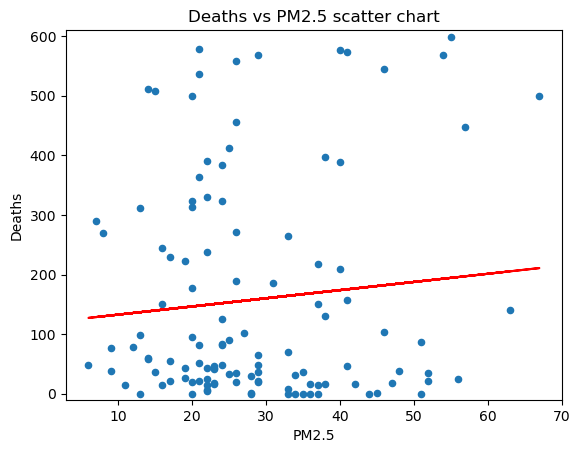

In [27]:
# 4.1.1) Deaths vs PM2.5
df_final.plot.scatter(x = 'pm25',
                     y = 'death',
                     ylim = (-10, 610)
                     )
# Add title and axis names
plt.title('Deaths vs PM2.5 scatter chart')
plt.xlabel('PM2.5')
plt.ylabel('Deaths')

# Create linear regression
X = df_final.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array ->PM2.5
Y = df_final.iloc[:, 3].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column-> Death
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='red')
plt.show()

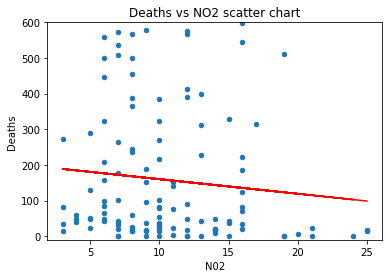

In [19]:
# 4.1.2) Deaths vs NO2
df_final.plot.scatter(x = 'no2',
                     y = 'death',
                     ylim = (-10, 600))
# Add title and axis names
plt.title('Deaths vs NO2 scatter chart')
plt.xlabel('N02')
plt.ylabel('Deaths')

# Create linear regression
X = df_final.iloc[:, 2].values.reshape(-1, 1)  # values converts it into a numpy array -> NO2
Y = df_final.iloc[:, 3].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column-> Death
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='red')
plt.show()

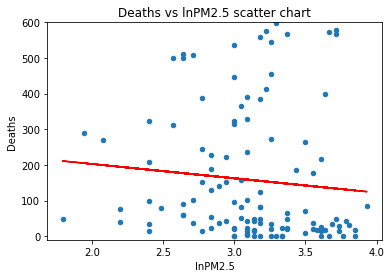

In [20]:
# 4.1.3) Deaths vs lnPM2.5
df_final.plot.scatter(x = 'ln_pm25',
                     y = 'death',
                     ylim = (-10, 600))
# Add title and axis names
plt.title('Deaths vs lnPM2.5 scatter chart')
plt.xlabel('lnPM2.5')
plt.ylabel('Deaths')

# Create linear regression
X = df_final.iloc[:, 4].values.reshape(-1, 1)  # values converts it into a numpy array ->lnPM2.5
Y = df_final.iloc[:, 3].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column-> Death
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='red')
plt.show()

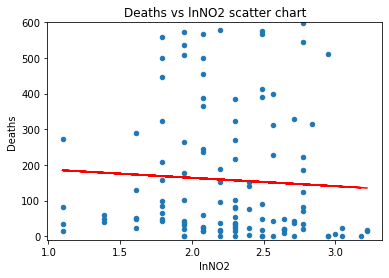

In [21]:
# 4.1.4) Deaths vs lnNO2
df_final.plot.scatter(x = 'ln_no2',
                     y = 'death',
                     ylim = (-10, 600))
# Add title and axis names
plt.title('Deaths vs lnNO2 scatter chart')
plt.xlabel('lnNO2')
plt.ylabel('Deaths')

#Create linear regression
X = df_final.iloc[:, 5].values.reshape(-1, 1)  # values converts it into a numpy array -> lnNO2
Y = df_final.iloc[:, 3].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column-> Death
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='red')
plt.show()

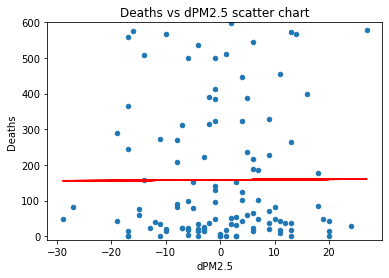

In [22]:
# 4.1.5) Deaths vs dPM2.5
df_final.plot.scatter(x = 'd_pm25',
                     y = 'death',
                     ylim = (-10, 600))
# Add title and axis names
plt.title('Deaths vs dPM2.5 scatter chart')
plt.xlabel('dPM2.5')
plt.ylabel('Deaths')

#Create linear regression
##small comment: DataFrame has NaN values so we have at least 2 solution: 
                    # 1. remove rows with NaN values
                    # 2. replace the NaN values with the mean -> I chose the second one because it seems more reasonable to me
                        ##if you have other suggestions tell me
            
X_new=df_final.iloc[:, 7].fillna(df_final.iloc[:, 7].mean()) #replace the NaN values with the mean 
X = X_new.values.reshape(-1, 1)  # values converts it into a numpy array -> dPM2.5
Y = df_final.iloc[:, 3].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column-> Death
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='red')
plt.show()

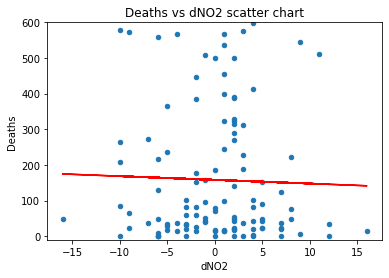

In [23]:
# 4.1.6) Deaths vs dNO2
df_final.plot.scatter(x = 'd_no2',
                     y = 'death',
                     ylim = (-10, 600)
                     )
# Add title and axis names
plt.title('Deaths vs dNO2 scatter chart')
plt.xlabel('dNO2')
plt.ylabel('Deaths')

#Create linear regression
X_new=df_final.iloc[:, 8].fillna(df_final.iloc[:, 8].mean()) #replace the NaN values with the mean
X = X_new.values.reshape(-1, 1)  # values converts it into a numpy array -> dNO2
Y = df_final.iloc[:, 3].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column-> Death
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, color='red')
plt.show()

## 4.2) Plotting by date

In [96]:
def plot_by_date(df, title):

  fig = px.line(df, x = 'date', y = 'death')

  fig.update_layout(title = title,
                  xaxis_title = 'Date', yaxis_title = 'Confirmed deaths',  
                  legend = dict(yanchor = "top", y = 0.99, xanchor = "right", x = 0.99))

  fig.update_traces(line_color='darkcyan', line_width = 3)

  fig.add_trace(go.Scatter(x = df['date'], y = [200]*len(df), 
                          mode = 'lines', name = '200 count line', 
                          line = dict(dash = 'dash', color = 'gray')))

  fig.add_trace(go.Scatter(x = df['date'], y = [400]*len(df), 
                          mode = 'lines', name = '400 count line', 
                          line = dict(dash = 'dash', color = 'maroon')))

  fig.add_trace(go.Scatter(x=df['date'], y = [600]*len(df), 
                          mode = 'lines', name = '600 count line', 
                          line = dict(dash = 'dash', color = 'black')))
  return(fig)


In [97]:
plot_by_date(df_final, "Timeline of Confirmed Deaths NYC")

In [28]:
# 4.2.1) Timeline of confirmed deaths
fig = px.line(df_final, x = 'date', y = 'death')

fig.update_layout(title = 'Timeline of confirmed deaths', 
                  xaxis_title = 'Date', yaxis_title = 'Confirmed deaths',  
                  legend = dict(yanchor = "top", y = 0.99, xanchor = "right", x = 0.99))

fig.update_traces(line_color='darkcyan', line_width = 3)

fig.add_trace(go.Scatter(x = df_final['date'], y = [200]*len(df_final), 
                          mode = 'lines', name = '200 count line', 
                          line = dict(dash = 'dash', color = 'gray')))

fig.add_trace(go.Scatter(x = df_final['date'], y = [400]*len(df_final), 
                          mode = 'lines', name = '400 count line', 
                          line = dict(dash = 'dash', color = 'maroon')))

fig.add_trace(go.Scatter(x=df_final['date'], y = [600]*len(df_final), 
                          mode = 'lines', name = '600 count line', 
                          line = dict(dash = 'dash', color = 'black')))

In [100]:
def pollutant_concentration(df,title):
 fig = px.line(df, x = 'date', y = 'pm25')

 fig.add_trace(go.Scatter(x = df.date, y = df.pm25, 
                        mode = 'lines', name = 'PM2.5', line_color = 'darkorange', line_width = 2))

 fig.add_trace(go.Scatter(x = df.date, y = df.no2, 
                        mode = 'lines', name = 'NO2', line_color = 'mediumblue', line_width = 2))

 fig.update_layout(title = title, 
                  xaxis_title = 'Date', yaxis_title = '$\\mu g / m^{3}$', 
                  legend = dict(yanchor = "top", y = 0.99, xanchor = "right", x = 0.99))
 return(fig)

In [101]:
pollutant_concentration(df_final, "Timeline of PM2.5 and NO2 concentration levels NYC")

In [29]:
# 4.2.2) Timeline of PM2.5 and NO2 concentration levels
fig = px.line(df_final, x = 'date', y = 'pm25')

fig.add_trace(go.Scatter(x = df_final.date, y = df_final.pm25, 
                        mode = 'lines', name = 'PM2.5', line_color = 'darkorange', line_width = 2))

fig.add_trace(go.Scatter(x = df_final.date, y = df_final.no2, 
                        mode = 'lines', name = 'NO2', line_color = 'mediumblue', line_width = 2))

fig.update_layout(title = 'Timeline of PM2.5 and NO2 concentration levels', 
                  xaxis_title = 'Date', yaxis_title = '$\\mu g / m^{3}$', 
                  legend = dict(yanchor = "top", y = 0.99, xanchor = "right", x = 0.99))

In [112]:
def deaths_vs_pollutant(df, pol, title):

 fig = px.bar(df.sort_values('death', ascending = False), 
       x = "date", y = "death", color = pol, 
       title = title,
       color_discrete_sequence = px.colors.qualitative.Vivid)

 fig.update_traces(textposition = 'outside')
 fig.update_layout(uniformtext_minsize = 8, uniformtext_mode = 'hide', xaxis_title = 'Date', yaxis_title = 'Confirmed deaths')
 fig.show()


###shows deaths vs pollutants, just change pol for the other pollutants, df for dataframe, and title is graph heading


In [113]:
deaths_vs_pollutant(df_final, "no2", "Deaths vs N02 over time NYC")

In [114]:
deaths_vs_pollutant(df_final, "pm25", "Deaths vs PM2.5 over time NYC")

In [30]:
# 4.2.3) Timeline of confirmed deaths and PM2.5 concentration levels
fig = px.bar(df_final.sort_values('death', ascending = False), 
       x = "date", y = "death", color = 'pm25', 
       title = 'Timeline of confirmed deaths and PM2.5 concentration levels',
       color_discrete_sequence = px.colors.qualitative.Vivid)

fig.update_traces(textposition = 'outside')
fig.update_layout(uniformtext_minsize = 8, uniformtext_mode = 'hide', xaxis_title = 'Date', yaxis_title = 'Confirmed deaths')
fig.show()

In [31]:
# 4.2.4) Timeline of confirmed deaths and NO2 concentration levels
fig = px.bar(df_final.sort_values('death', ascending = False), 
       x = "date", y = "death", color = 'no2', 
       title = 'Deaths and NO2 concentration levels over time',
       color_discrete_sequence = px.colors.qualitative.Vivid)

fig.update_traces(textposition = 'outside')
fig.update_layout(uniformtext_minsize = 8, uniformtext_mode = 'hide', xaxis_title = 'Date', yaxis_title = 'Confirmed deaths')
fig.show()

# 5) Prediction with Artificial Neural Networks (ANNs)
## 5.1) Something with Apache Spark -> Oryx 2.8.0

In [2]:
pip install spylon-kernel

  Created wheel for spylon-kernel: filename=spylon_kernel-0.4.1-py2.py3-none-any.whl size=18370 sha256=f15db843211126a04316e286be606106c4454f93553ba1459fe2a0df8410eb83
  Stored in directory: c:\users\maxim\appdata\local\pip\cache\wheels\f8\f1\04\7b6c8644c458aeb767c82f459c06b8074c63339e8c5654e551
  Created wheel for spylon: filename=spylon-0.3.0-py3-none-any.whl size=136189 sha256=f79cc85f9b13fe88210a06c9ebd881f11571cc47d4d6d7db12263589c81b547f
  Stored in directory: c:\users\maxim\appdata\local\pip\cache\wheels\2e\df\61\860b966d814585b16ac84f72060ca1578b17bdb7f8684f26d6
Successfully built spylon-kernel spylon
Note: you may need to restart the kernel to use updated packages.


In [4]:
# run this ins anaconda powershell prompt
python -m spylon_kernel install

SyntaxError: invalid syntax (4040037691.py, line 1)

In [5]:
sudo apt install default-jdk scala git -y

SyntaxError: invalid syntax (886566313.py, line 1)